In [1]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from timeit import default_timer as tdt

from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

if torch.cuda.is_available():
    my_device = 'cuda'
else:
    my_device = 'cpu'

In [17]:
## ========= SIMULATION SETTINGS =========
omega0 = 2.0
lambd = 0.5
t0 = torch.tensor([0.0], device=my_device, requires_grad=True)
x0 = torch.tensor([1.0], device=my_device)
x0_dot = torch.tensor([0.0], device=my_device)
t_span = (0, 10)

In [4]:
# Numerical solution
from scipy.integrate import solve_ivp

# Define the system of ODEs
def damped_oscillator(t, y):
    x, v = y
    dxdt = v
    dvdt = -lambd * v - omega0**2 * x
    return [dxdt, dvdt]

# Initial conditions vector
init_conditions = [x0.to('cpu').detach().numpy()[0], x0_dot.to('cpu').detach().numpy()[0]]

# Solve the ODE
solution = solve_ivp(damped_oscillator, t_span, init_conditions, t_eval=np.linspace(t_span[0], t_span[1], 1000))

# Extract the results
t_num = solution.t
x_num = solution.y[0,:]
x_dot_num = solution.y[1,:]

# Getting points for implementation in network training_
t_num_train_save = torch.tensor(t_num[50:501:50], device=my_device).view(-1,1).to(torch.float32)
x_num_train_save = torch.tensor(x_num[50:501:50], device=my_device).view(-1,1).to(torch.float32)
x_dot_num_train_save = torch.tensor(x_dot_num[50:501:50], device=my_device).view(-1,1).to(torch.float32)

In [8]:
# Define loss functions
# Use torches MSE loss.
torch_MSE_loss = torch.nn.MSELoss()

def loss_ODE(t, omega0, lambd, net):
    
    # Calculate u from the network
    x_net = net(t)

    # Take gradient of network w.r.t. the input t. This is u'(t)
    dxdt = torch.autograd.grad(x_net, t, grad_outputs=torch.ones_like(x_net), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt,  t, grad_outputs=torch.ones_like(x_net), create_graph=True)[0]

    # Left hand side. https://en.wikipedia.org/wiki/Harmonic_oscillator
    lhs = d2xdt2
    
    # Right hand side.
    rhs = - omega0**2*x_net - lambd*dxdt
    
    # Calculate the MSE of the residual
    loss_ODE = torch_MSE_loss(rhs, lhs)

    return loss_ODE
    
def loss_IC(t0, x0, v0, net):
    # Ensure correct shape
    t0 = t0.view(-1,1)
    x0 = x0.view(-1,1)
    
    # Get network response to initial condition
    x0_net = net(t0)

    # Compare to initial condition WE choose
    # Displacement initial condition
    loss_IC_disp = torch_MSE_loss(x0_net, x0)
    
    # Velocity IC
    v0_net = torch.autograd.grad(x0_net, t0, grad_outputs=torch.ones_like(x0_net), create_graph=True)[0][0]
    loss_IC_vel = torch_MSE_loss(v0_net, v0)

    return loss_IC_disp, loss_IC_vel

def loss_data_points(tntrain, xntrain, xdotntrain, net):
    x_net = net(tntrain)

    loss_dp_f = torch_MSE_loss(x_net, xntrain)
    
    return loss_dp_f

In [10]:
# Define network
class FFN(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size):
        super(FFN, self).__init__()
        
        n_layers = len(hidden_layers_size)
        HL = hidden_layers_size
        
        # Define layers
        self.L1 = nn.Linear(input_size, HL[0], bias=True)
        self.L2 = nn.Linear(HL[0], HL[1], bias=True)
        self.L3 = nn.Linear(HL[1], HL[2], bias=True)
        self.L4 = nn.Linear(HL[2], HL[3], bias=True)
        self.L5 = nn.Linear(HL[3], HL[4], bias=True)
        self.L6 = nn.Linear(HL[4], HL[5], bias=True)
        self.L7 = nn.Linear(HL[5], HL[6], bias=True)
        self.L8 = nn.Linear(HL[6], HL[7], bias=True)
        self.L9 = nn.Linear(HL[7], HL[8], bias=True)
        self.L10 = nn.Linear(HL[8], HL[9], bias=True)
        self.L11 = nn.Linear(HL[9], HL[-1], bias=True)
        
        self.output = nn.Linear(HL[-1], output_size, bias=True)
        
        # Define activation function
        self.act_fn = nn.Tanh()

    def forward(self, x):
        # Hidden layers
        x = self.L1(x)
        x = self.act_fn(x)
        
        x = self.L2(x)
        x = self.act_fn(x)
        
        x = self.L3(x)
        x = self.act_fn(x)
        
        x = self.L4(x)
        x = self.act_fn(x)
        
        x = self.L5(x)
        x = self.act_fn(x)
        
        x = self.L6(x)
        x = self.act_fn(x)

        x = self.L7(x)
        x = self.act_fn(x)
        
        x = self.L8(x)
        x = self.act_fn(x)
        
        x = self.L9(x)
        x = self.act_fn(x)

        x = self.L10(x)
        x = self.act_fn(x)
        
        x = self.L11(x)
        x = self.act_fn(x)

        # Output layer
        x = self.output(x)
        
        return x

# Define network
net = FFN(1, [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512], 1).to(my_device)

# Print Network shape
print()
print(net.parameters)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



<bound method Module.parameters of FFN(
  (L1): Linear(in_features=1, out_features=512, bias=True)
  (L2): Linear(in_features=512, out_features=512, bias=True)
  (L3): Linear(in_features=512, out_features=512, bias=True)
  (L4): Linear(in_features=512, out_features=512, bias=True)
  (L5): Linear(in_features=512, out_features=512, bias=True)
  (L6): Linear(in_features=512, out_features=512, bias=True)
  (L7): Linear(in_features=512, out_features=512, bias=True)
  (L8): Linear(in_features=512, out_features=512, bias=True)
  (L9): Linear(in_features=512, out_features=512, bias=True)
  (L10): Linear(in_features=512, out_features=512, bias=True)
  (L11): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=1, bias=True)
  (act_fn): Tanh()
)>


In [11]:
t_test = torch.rand(5, 1, requires_grad=True, device=my_device) * t_span[-1]
print(t_test)

net.train()
loss_from_ODE = loss_ODE(t_test, omega0, lambd, net)
print(loss_from_ODE)
loss_IC_x0, loss_IC_v0 = loss_IC(t0, x0, x0_dot, net)
print(loss_IC_x0)
print(loss_IC_v0)
loss_dp = loss_data_points(t_num_train_save, x_num_train_save, x_dot_num_train_save, net)
print(loss_dp)

tensor([[5.8923],
        [1.3675],
        [6.4848],
        [1.5032],
        [7.4887]], device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0532, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.6674e-08, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1480, device='cuda:0', grad_fn=<MseLossBackward0>)


In [12]:
# Loss saving
loss_saved, ode_res_saved, IC_loss_saved = [], [], []
adapt_ode_loss_saved, adapt_IC_loss_saved = [], []
epochs_saved = [0]
# SoftAdapt setup
softadapt_obj  = SoftAdapt(beta=0.1)
epochs_to_make_change = 5
adapt_weights = torch.tensor([1,1,1])    # Initial weighting of objects.


In [15]:
# Setup optimizer
learning_rate = 3e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training setup
num_epochs = 1000
save_every_epochs = 100
batch_size = 512

loss1, loss2, loss3 = [], [], []
net = net.to(my_device)
start_whole = tdt()
# Train the model
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    # Sample t, lambda in domain
    #t_points = torch.rand(batch_size, 1, device=my_device, requires_grad=True) * t_span[1]
    # Fixed point like Karpathy
    t_points = torch.linspace(0, 10, batch_size, device=my_device, requires_grad=True).view(-1,1)
    
    # Calculate loss
    # Loss from ODE
    loss_from_ODE = loss_ODE(t_points, omega0, lambd, net)
    # Loss from IC
    loss_x0, loss_v0 = loss_IC(t0, x0, x0_dot, net)
    loss_from_IC = loss_x0 + loss_v0
    # Loss from Datapoints
    t_num_train = torch.clone( t_num_train_save )
    x_num_train = torch.clone( x_num_train_save )
    loss_data = loss_data_points(t_num_train, x_num_train, None, net)
    
    loss1.append( loss_from_ODE )
    loss2.append( loss_from_IC )
    loss3.append( loss_data )

    # SoftAdapt
    if epoch % epochs_to_make_change == 0 and epoch != 0:
        adapt_weights = softadapt_obj.get_component_weights(torch.tensor(loss1),
                                                            torch.tensor(loss2),
                                                            torch.tensor(loss3),
                                                            verbose=False)
        loss1, loss2, loss3 = [], [], []
    
    loss = adapt_weights[0] * loss_from_ODE + adapt_weights[1] * loss_from_IC + adapt_weights[2] * loss_data
    #loss = loss_from_ODE + loss_from_IC

    loss.backward()
    optimizer.step()
          
    if (epoch+1) % save_every_epochs == 0 or epoch == 0:
        print(f"Epoch {epoch+1:6}, Loss: {loss.item():8.5f}, ode_loss: {loss_from_ODE:8.7f}, ic_loss: {loss_from_IC:8.7f}"
              f", aw[0]: {adapt_weights[0]:8.5f}, aw[1]: {adapt_weights[1]:8.5f}, aw[2]: {adapt_weights[2]:8.5f}")
        epochs_saved.append(epoch+1)
        loss_saved.append(loss.item())
        ode_res_saved.append(loss_from_ODE.detach().to('cpu'))
        IC_loss_saved.append(loss_from_IC.detach().to('cpu'))
        adapt_ode_loss_saved.append( adapt_weights[0]*loss_from_ODE.detach().to('cpu') )
        adapt_IC_loss_saved.append( adapt_weights[1]*loss_from_IC.detach().to('cpu') )


Epoch      1, Loss:  0.00743, ode_loss: 0.0192336, ic_loss: 0.0000835, aw[0]:  0.33428, aw[1]:  0.33286, aw[2]:  0.33286
Epoch    100, Loss:  0.01613, ode_loss: 0.0372213, ic_loss: 0.0007097, aw[0]:  0.33411, aw[1]:  0.33292, aw[2]:  0.33297
Epoch    200, Loss:  0.00861, ode_loss: 0.0208710, ic_loss: 0.0001503, aw[0]:  0.33342, aw[1]:  0.33332, aw[2]:  0.33326
Epoch    300, Loss:  0.00502, ode_loss: 0.0136350, ic_loss: 0.0000136, aw[0]:  0.33332, aw[1]:  0.33333, aw[2]:  0.33335
Epoch    400, Loss:  0.00455, ode_loss: 0.0123896, ic_loss: 0.0000217, aw[0]:  0.33335, aw[1]:  0.33333, aw[2]:  0.33332
Epoch    500, Loss:  0.00369, ode_loss: 0.0104164, ic_loss: 0.0000097, aw[0]:  0.33333, aw[1]:  0.33333, aw[2]:  0.33334
Epoch    600, Loss:  0.00295, ode_loss: 0.0082611, ic_loss: 0.0000116, aw[0]:  0.33333, aw[1]:  0.33333, aw[2]:  0.33333
Epoch    700, Loss:  0.00253, ode_loss: 0.0070518, ic_loss: 0.0000012, aw[0]:  0.33322, aw[1]:  0.33340, aw[2]:  0.33339
Epoch    800, Loss:  0.00127, od

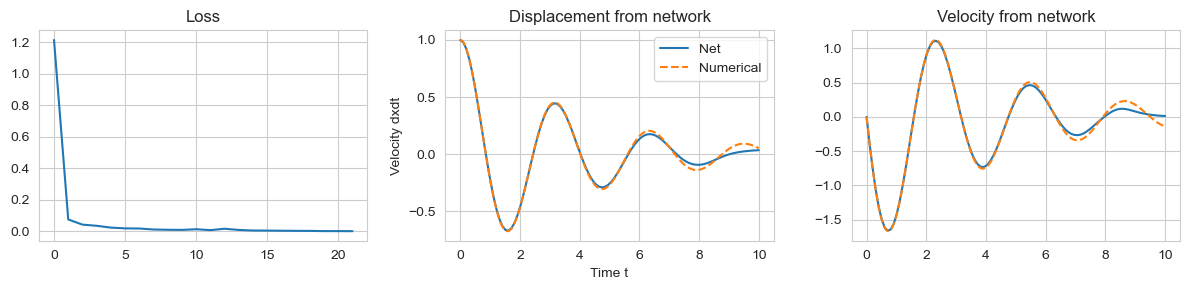

In [16]:
# Illustrating solution
fig, ax = plt.subplots(1, 3, figsize=(12,3))
ax[0].plot(loss_saved)
ax[0].set_title('Loss')

net_cpu = net.to('cpu')
t_lin = torch.linspace(0, 10, 100, requires_grad=True).view(-1,1)
x_lin = net_cpu(t_lin)
dxdt = torch.autograd.grad(x_lin, t_lin, grad_outputs=torch.ones_like(x_lin), create_graph=True)[0]

# Plot position numerical and network
ax[1].set_title('Displacement from network')
ax[1].plot(t_lin.detach().numpy(), x_lin.detach().numpy(), label='Net')
ax[1].plot(t_num, x_num, label='Numerical', linestyle='--')
ax[1].set_ylabel('Displacement x')
ax[1].set_xlabel('Time t')
ax[1].legend()

# Calculate velocity numerical and network
ax[2].set_title('Velocity from network')
ax[2].plot(t_lin.detach().numpy(), dxdt.detach().numpy(), label='Net')
ax[2].plot(t_num, x_dot_num, label='Numerical', linestyle='--')
ax[1].set_ylabel('Velocity dxdt')
ax[1].set_xlabel('Time t')
ax[1].legend()

plt.tight_layout()